In [294]:
# 设置参数
trainSetPercent = 0.35
num_iterations = 100
learning_rate = 0.001
loadLastTrainData = True
sliceRandomSeed = 0
useCupy = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
# 准备数据
import pandas as pd
import psutil
import math
import matplotlib.pyplot as plt
import utils

if useCupy:
    import cupy as np
    import numpy
else:
    import numpy as np

labels= pd.read_csv('labels_final.csv')
print('data set count:', labels.shape[0])


trainSetCount = math.floor(labels.shape[0] * trainSetPercent)
if trainSetCount < 1: trainSetCount = 1
testSetCount = labels.shape[0] - trainSetCount

print('train set count:', trainSetCount)
print('test set count:', testSetCount)

imgDir = './images/resized/'
imgSize = 0

np.random.seed = sliceRandomSeed
shuffledDataSet = np.array(labels)
np.random.shuffle(shuffledDataSet)
trainSetRange = shuffledDataSet[:trainSetCount, :]
testSetRange = shuffledDataSet[trainSetCount:trainSetCount + testSetCount, :]

trainSetX = []

for row in trainSetRange:
    img = plt.imread(imgDir + str(row[0]) + '.jpg')
    if imgSize == 0: imgSize = img.size
    elif imgSize != img.size:
        raise ValueError("图片尺寸不一致")
    imgArray = np.array(img)
    imgTrans = imgArray.reshape((1, img.size)).T
    trainSetX.append(imgTrans)

print('image size:', imgSize)

data set count: 5996
train set count: 2098
test set count: 3898
image size: 82944


In [296]:
# 构造训练集
trainSetX = np.array(trainSetX)
trainSetX = trainSetX.squeeze().T / 2550
trainSetY = trainSetRange[:,1:].T

In [297]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters     


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


In [298]:

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

def initialize_parameters_deep(layer_dims):
    # np.random.seed(1)
    # parameters = {}
    # L = len(layer_dims)
    # print (layer_dims)
    # for i in range(1, L):
    #     #Be careful, the scaler is np.sqrt(layers_dims[i - 1]), not constant 0.01
    #     parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) / np.sqrt(layer_dims[i - 1])
    #     parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
        
    #     assert((layer_dims[i], layer_dims[i - 1]) == parameters["W" + str(i)].shape)
    #     assert((layer_dims[i], 1) == parameters["b" + str(i)].shape)
    
    # return parameters
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for i in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, np.array(parameters["W" + str(L)]), np.array(parameters["b" + str(L)]), "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -(np.dot(np.log(AL), Y.T) + np.dot(np.log(1 - AL), (1 - Y).T)) / (m * 1.0)
    cost = np.squeeze(cost)
    assert(cost.shape == ( ))
    return cost

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for i in reversed(range(L - 1)):
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(i + 2)], current_cache, activation="relu")
        grads["dA" + str(i + 1)] = dA_prev_temp
        grads["dW" + str(i + 1)] = dW_temp
        grads["db" + str(i + 1)] = db_temp
        
    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for i in range(1, L + 1):
        parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] -= learning_rate * grads["db" + str(i)]
        
    return parameters

# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, saved_parameters = None, cost_record_cnt = 10, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    if cost_record_cnt <= 0: cost_record_cnt = num_iterations
    recordCostInterval = max(math.floor(num_iterations / cost_record_cnt), 1)

    # np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = saved_parameters
    if parameters == None:
        parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ## START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        # if print_cost and i % 5 == 0:
        #     print ("Cost after iteration %i: %f" %(i, cost))
        # if print_cost and i % 5 == 0:
        #     costs.append(cost)
        if i % recordCostInterval == 0:
            costs.append(cost)
            if print_cost:
                print ("Progress: %s cost: %.4f" % (utils.strProgress(i, num_iterations, 20), cost))
            
    costs = np.array(costs)
    # plot the cost
    if useCupy:
        plt.plot(numpy.squeeze(costs.get()))
    else:
        plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

memory used 38.755 GB of 63.732 GB | 61 %
Progress: [....................] cost: 0.3495
Progress: [#...................] cost: 0.3004
Progress: [##..................] cost: 0.2962
Progress: [###.................] cost: 0.2927
Progress: [####................] cost: 0.2896
Progress: [#####...............] cost: 0.2868
Progress: [######..............] cost: 0.2841
Progress: [#######.............] cost: 0.2817
Progress: [########............] cost: 0.2793
Progress: [#########...........] cost: 0.2770
Progress: [##########..........] cost: 0.2748
Progress: [###########.........] cost: 0.2726
Progress: [############........] cost: 0.2704
Progress: [#############.......] cost: 0.2683
Progress: [##############......] cost: 0.2663
Progress: [###############.....] cost: 0.2643
Progress: [################....] cost: 0.2623
Progress: [#################...] cost: 0.2604
Progress: [##################..] cost: 0.2584
Progress: [###################.] cost: 0.2565


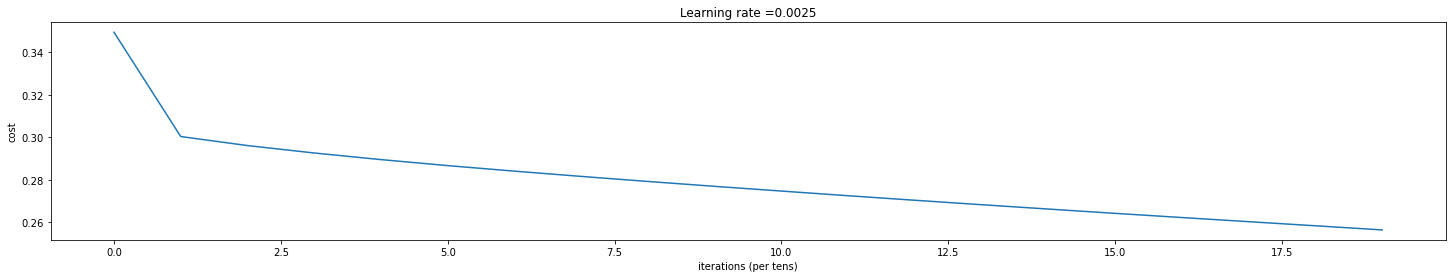

In [299]:
memUsage = psutil.virtual_memory()
print('memory used %.3f GB of %.3f GB | %.0f %%' % (memUsage.used / 1024 / 1024 / 1024, memUsage.total / 1024 / 1024 / 1024, memUsage.percent))

layers_dims = [imgSize, 20, 7, 5, 1] #  5-layer model
import utils
if useCupy: saveDataFilePath = './saved_parameters_cupy.bin'
else: saveDataFilePath = './saved_parameters.bin'
saved_parameters = utils.loadFromeFile(saveDataFilePath)
plt.rcParams['figure.figsize'] = (25.0, 4.0)
parameters = L_layer_model(trainSetX, trainSetY, layers_dims, num_iterations = 1000, learning_rate = 0.0025, cost_record_cnt = 20, saved_parameters = saved_parameters, print_cost = True)

In [300]:
# 保存模型

utils.save2File(parameters, saveDataFilePath)
print('save to', saveDataFilePath, 'done')

save to ./saved_parameters.bin done


In [301]:
# 构造测试集
testSetX = []

for row in testSetRange:
    img = plt.imread(imgDir + str(row[0]) + '.jpg')
    if imgSize != img.size:
        raise ValueError("图片尺寸不一致")
    imgArray = np.array(img)
    imgTrans = imgArray.reshape((1, img.size)).T
    testSetX.append(imgTrans)

testSetX = np.array(testSetX).squeeze().T / 2550
testSetY = testSetRange[:,1:].T

print(testSetX.shape)
print(testSetY.shape)

(82944, 3898)
(1, 3898)


In [302]:
YHat, _ = L_model_forward(testSetX, parameters)
print(YHat.shape)
if useCupy:
    result = np.array(numpy.vectorize(lambda x: 1 if x > 0.5 else 0)((YHat - testSetY).get()))
else:
    result = np.vectorize(lambda x: 1 if x > 0.5 else 0)(YHat - testSetY)
print(result)
goodCaseCnt = np.count_nonzero(result == 0)
print('Accuracy: %.2f %%' % (100 * goodCaseCnt / testSetY.shape[1]))

(1, 3898)
[[0 0 0 ... 0 0 0]]
Accuracy: 92.97 %
